In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont

In [2]:
def get_existing_chars(filename):
    ttfont = TTFont(filename)
    return list({chr(key) for table in ttfont['cmap'].tables for key in table.cmap.keys()})

In [3]:
def get_image(font, char, size=96):
    img = Image.new('L', (500,500), 255)
    
    draw = ImageDraw.Draw(img)
    draw.text((0,0), char, font=font)
    
    npimg = 255 - np.array(img)
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()
    
    npimg = 255 - npimg[hmin:hmax+1,wmin:wmax+1]
    
    whdiff = (wmax-wmin) - (hmax-hmin)
    wmargin = abs(whdiff) // 2 if whdiff < 0 else 0
    hmargin = abs(whdiff) // 2 if whdiff >= 0 else 0

    npimg = np.pad(npimg, ((hmargin, hmargin), (wmargin, wmargin)),
                       'constant', constant_values=255)
    img = Image.fromarray(npimg).resize((size, size), resample=Image.BILINEAR)
    return img
    

In [4]:
# utf-8
def get_all_korean():
    
    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()
    
    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns
    

In [5]:
ak = get_all_korean()

In [6]:
len(ak)

11172

In [7]:
fd = "data/r40202/ttfs/"
ttfs = [(fd+f, f.split(".ttf")[0]) for f in os.listdir(fd) if ".ttf" in f]

In [8]:
ttfs[0]

('data/r40202/ttfs/AppleGothic.ttf', 'AppleGothic')

In [9]:
png_fd = "data/r40202/pngs/"

In [10]:
chardf = pd.DataFrame(ak)
chardf.to_parquet("data/r40202/all_korean.parquet")
pbar = tqdm(range(len(ttfs)))
c = 0
for i in pbar:
    ttf = ttfs[i]
    filename = ttf[0]
    try:
        font = ImageFont.truetype(filename,255)
        existing_chars = get_existing_chars(filename)
        savepics = True
    except:
        savepics = False
    if savepics:
        for j in range(len(chardf)):
            if not os.path.exists(png_fd+'%s__%s.png'%(ttf[1],str(j))):
                char = chardf.iloc[j].values[0]
                if char in existing_chars:
                    try:
                        img = get_image(font, char)
                        with open(png_fd+'%s__%s.png'%(ttf[1],str(j)), "wb") as f:
                            img.save(f, "PNG")
                    except:
                        # print(ttf[1], ttf[2], char)
                        c += 1
                else:
                    c += 1
    pbar.set_postfix(passed=str(c), files=str(len(os.listdir(png_fd))))

100%|██████████| 347/347 [28:59<00:00,  5.01s/it, files=526686, passed=3327654]


In [11]:
all_pngs = [f for f in os.listdir(png_fd) if ".png" in f]
for t in ttfs:
    n_letters = len([f for f in all_pngs if t[1] in f])
    if n_letters > 10000:
        print(t[1], n_letters)
    elif n_letters > 5000:
        print(t[1], n_letters)

AppleGothic 11172
Arial Unicode 11172
twice sana_4 11172
AppleMyungjo 11172
gulim 11172
twice jihyo_4 11172
twice momo_6 11172
Arial 11172
twice dahyun_4 11172
UhBee MiMi 5456
twice mina_4 11172
twice jeongyeon_4 11172
twice nayeon_6 11172
twice tzuyu_4 11172


In [23]:
[p for p in all_pngs if "twice momo_6" in p]

['twice momo_6__507.png',
 'twice momo_6__8281.png',
 'twice momo_6__5778.png',
 'twice momo_6__8306.png',
 'twice momo_6__7867.png',
 'twice momo_6__4937.png',
 'twice momo_6__1693.png',
 'twice momo_6__1880.png',
 'twice momo_6__2718.png',
 'twice momo_6__7250.png',
 'twice momo_6__2726.png',
 'twice momo_6__5710.png',
 'twice momo_6__8456.png',
 'twice momo_6__5138.png',
 'twice momo_6__2475.png',
 'twice momo_6__6622.png',
 'twice momo_6__1444.png',
 'twice momo_6__7797.png',
 'twice momo_6__9610.png',
 'twice momo_6__4223.png',
 'twice momo_6__2599.png',
 'twice momo_6__10921.png',
 'twice momo_6__9840.png',
 'twice momo_6__2105.png',
 'twice momo_6__4407.png',
 'twice momo_6__3069.png',
 'twice momo_6__4334.png',
 'twice momo_6__5093.png',
 'twice momo_6__653.png',
 'twice momo_6__3133.png',
 'twice momo_6__2541.png',
 'twice momo_6__6094.png',
 'twice momo_6__5784.png',
 'twice momo_6__8639.png',
 'twice momo_6__7851.png',
 'twice momo_6__11154.png',
 'twice momo_6__831.png',
 '

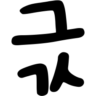

In [25]:
Image.open("data/r40202/pngs/twice momo_6__507.png")

In [28]:
ttfs[1]
ttf = ttfs[1]
filename = ttf[0]

In [29]:
filename

'data/r40202/ttfs/NotoSansSundanese-Regular.ttf'

In [30]:
font = ImageFont.truetype(filename,255)
existing_chars = get_existing_chars(filename)

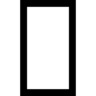

In [38]:
get_image(font, '바')

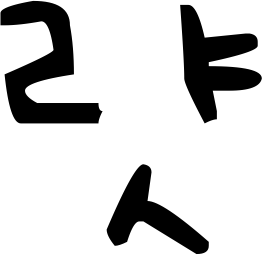

In [138]:
img = Image.open(files[int(random.random()*len(files))])
img

In [5]:
img

NameError: name 'img' is not defined

In [19]:
char

'힣'

In [4]:
for p in tqdm(os.listdir(png_fd)):
    try:
        os.remove(png_fd+p)
    except:
        pass

100%|██████████| 59187/59187 [00:01<00:00, 50247.78it/s]


In [12]:
font = ImageFont.truetype("data/r40202/ttfs/gulim.ttf",255)

In [13]:
img = get_image(font, ak[0])

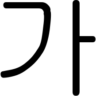

In [14]:
img

In [42]:
for p in tqdm(os.listdir(png_fd)):
    os.remove(png_fd+p)

100%|██████████| 526686/526686 [00:14<00:00, 36321.10it/s]
